In [2]:
import pandas as pd
from pathlib import Path
import os
import csv
import glob
import shutil
from collections import Counter
import numpy as np
import tensorflow as tf
import keras
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import sklearn
from random import shuffle
from keras.layers import *
from keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from itertools import chain
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

In [3]:
x1 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client1_data.npy')
x2 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client2_data.npy')
x3 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client3_data.npy')
x4 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client4_data.npy')

y1_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client1_label.npy')
y2_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client2_label.npy')
y3_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client3_label.npy')
y4_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client4_label.npy')

x_test = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/test_data.npy')
y_test_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/test_label.npy')

In [4]:
def split_dataset(x_test, y_test_encoded, num_splits=40):
    """
    Splits a dataset into smaller datasets such that all classes are present in each split.
    Returns:
        list: A list of tuples, where each tuple contains a smaller dataset (x_split, y_split).
    """   
    # StratifiedKFold will split maintaining class distribution
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    y_test = np.argmax(y_test_encoded, axis=1)
    
    splits = []
    for _, split_indices in tqdm(skf.split(x_test, y_test)):
        x_split = x_test[split_indices]
        y_split = y_test[split_indices]
        splits.append((x_split, y_split))
    
    return splits

# Split into 20 parts
splits = split_dataset(x_test, y_test_encoded, num_splits=30)

# # Example: Check the size and classes in each split
# for i, (x_split, y_split) in enumerate(splits):
#     print(f"Split {i+1}: {len(x_split)} samples, Classes: {np.unique(y_split)}")

30it [00:01, 17.17it/s]


In [5]:
x_val = splits[0][0]
y_val_encoded = to_categorical(splits[0][1])

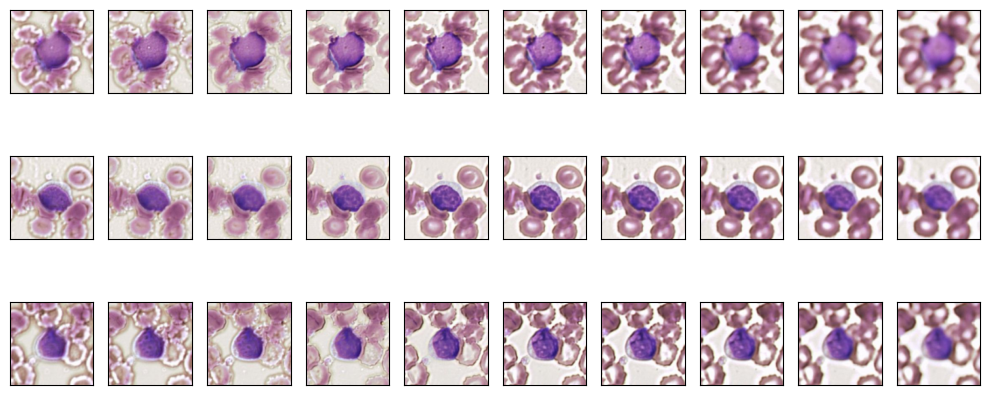

In [15]:
plt.figure(figsize=(10,5))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow((x3[i] * 255).astype(np.uint8))
plt.show()

In [6]:
def dense_block(x, repetitions, filters):
    for _ in range(repetitions):
        y = BatchNormalization()(x)
        y = ReLU()(y)
        y = Conv2D(4 * filters, 1, padding='same')(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        y = Conv2D(filters, 3, padding='same')(y)
        x = concatenate([y, x])
    return x

def transition_layer(x):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(K.int_shape(x)[-1] // 2, 1, padding='same')(x)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.1)(x)
    return x

def DenseNet121(input_shape=(128, 128, 3), num_classes=16):
    inputs = Input(input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 6, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 12, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 24, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 16, 32)
    x = Dropout(0.1)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

#model = DenseNet121()
#model.summary()

In [8]:
### federated Learning full model aggregation ###
 ## 4 models for 4 clients ##
model1 = DenseNet121()
model2 = DenseNet121()
model3 = DenseNet121()
model4 = DenseNet121()
################################################################
LR = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=LR, decay_steps=1000, decay_rate=0.1) #should be < 1, or lr rate increa
optim = optimizers.Adam(learning_rate=lr_schedule)

filepath1 = '/mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_{val_accuracy:.3f}-loss_{val_loss:.3f}.keras'
checkpoint1 = ModelCheckpoint(filepath=filepath1, monitor='loss',verbose=1, save_best_only=False, mode='min')

filepath2 = '/mnt/c/Users/Dhruba/Codes/saved models/WBC_fd2_dns.v_acc_{val_accuracy:.3f}-loss_{val_loss:.3f}.keras'
checkpoint2 = ModelCheckpoint(filepath=filepath2, monitor='loss',verbose=1, save_best_only=False, mode='min')

filepath3 = '/mnt/c/Users/Dhruba/Codes/saved models/WBC_fd3_dns.v_acc_{val_accuracy:.3f}-loss_{val_loss:.3f}.keras'
checkpoint3 = ModelCheckpoint(filepath=filepath3, monitor='loss',verbose=1, save_best_only=False, mode='min')

filepath4 = '/mnt/c/Users/Dhruba/Codes/saved models/WBC_fd4_dns.v_acc_{val_accuracy:.3f}-loss_{val_loss:.3f}.keras'
checkpoint4 = ModelCheckpoint(filepath=filepath4, monitor='loss',verbose=1, save_best_only=False, mode='min')

model1.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics=['accuracy'])
model3.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics=['accuracy'])
model4.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

val_loss = []
val_acc = []

  ###training 4 models for 4 clients
for i in tqdm(range(20)):
    #print("Starting client 1 training")
    
    model1.fit(x1, y1_encoded, epochs=1, batch_size=40, verbose=1, validation_data=(x_val, y_val_encoded), callbacks=[checkpoint1]) ## validation_data=(x_test, y_test)
    #print("Starting client 2 training")
    model2.fit(x2, y2_encoded, epochs=1, batch_size=40, verbose=1, validation_data=(x_val, y_val_encoded), callbacks=[checkpoint2])
    #print("Starting client 3 training")
    model3.fit(x3, y3_encoded, epochs=1, batch_size=40, verbose=1, validation_data=(x_val, y_val_encoded), callbacks=[checkpoint3])
    #print("Starting client 4 training")
    model4.fit(x4, y4_encoded, epochs=1, batch_size=40, verbose=1, validation_data=(x_val, y_val_encoded), callbacks=[checkpoint4])

    # w1 = model1.get_weights()
    # w2 = model2.get_weights()
    # w3 = model3.get_weights()
    # w4 = model4.get_weights()

    # a = np.array(w1, dtype="object")
    # b = np.array(w2, dtype="object")
    # c = np.array(w3, dtype="object")
    # d = np.array(w4, dtype="object")

    # mean = (a+b+c+d)/4

    # model1.set_weights(mean)
    # model2.set_weights(mean)
    # model3.set_weights(mean)
    # model4.set_weights(mean) 

    ### for plot later ###
    vl, va = model1.evaluate(x_val, y_val_encoded)
    val_loss.append(vl)
    val_acc.append(va)

print("/n/n Done with federated training")

KeyboardInterrupt: 

In [ ]:
ep = list(range(0, 200))

# Plot the second list
plt.plot(ep, val_loss, label='val loss')
# Add labels and title
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Federated loss with layer aggregation')
# Add a legend
plt.legend()
# Show the plot
plt.show()

In [ ]:
ep = list(range(0, 200))
# Plot the first list
# Plot the second list
plt.plot(ep, val_acc, label='val acc')
# Add labels and title
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Federated accuracy with layer aggregation')
# Add a legend
plt.legend()
# Show the plot
plt.show()

In [9]:
def split_dataset(x_test, y_test_encoded, num_splits):
    """
    Splits a dataset into smaller datasets such that all classes are present in each split.
    Returns:
        list: A list of tuples, where each tuple contains a smaller dataset (x_split, y_split).
    """   
    # StratifiedKFold will split maintaining class distribution
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    y_test = np.argmax(y_test_encoded, axis=1)
    
    splits = []
    for _, split_indices in tqdm(skf.split(x_test, y_test)):
        x_split = x_test[split_indices]
        y_split = y_test[split_indices]
        splits.append((x_split, y_split))
    
    return splits

# Split into 20 parts
splits = split_dataset(x_test, y_test_encoded, num_splits=20)

# Example: Check the size and classes in each split
for i, (x_split, y_split) in enumerate(splits):
    print(f"Split {i+1}: {len(x_split)} samples, Classes: {np.unique(y_split)}")

# x_val = splits[10][0]
# y_val = splits[10][1]
# y_val = to_categorical(y_val)

20it [00:01, 11.62it/s]


Split 1: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 2: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 3: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 4: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 5: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 6: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 7: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 8: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 9: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 10: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 11: 1274 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 12: 1274 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 13: 127

In [13]:
# Specify the folder containing the .keras files
folder_path = "/mnt/c/Users/Dhruba/Codes/saved models"
split_num = 20  #carefully check the total splits of test set

# Use glob to find all .keras files in the folder
keras_files = glob.glob(os.path.join(folder_path, "*.keras"))
# Iterate through each file
for file_path in keras_files:
    print(file_path)
    best_model = load_model(file_path, compile = True)
    accuracy_list = []
    mac_auc = []
    mic_auc = [] 
    for i in tqdm(range(split_num)):  
        x = splits[i][0]
        y = splits[i][1]
        
        y_pred = best_model.predict(x, batch_size=40,  verbose=0)
        sparse_pred = np.argmax(y_pred, axis=1)
        
        ### Calculate accuracy
        accuracy = accuracy_score(y, sparse_pred)
        #print("Accuracy:", accuracy)
        accuracy_list.append(accuracy)
    
        # Calculate macro-averaged AUC
        macro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="macro") 
        mac_auc.append(macro_auc)
        # Calculate micro-averaged AUC
        micro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="micro") 
        mic_auc.append(micro_auc)
       
    total_acc = sum(accuracy_list[:split_num])/split_num
    print("Accuracy of model on full test data: ", total_acc)
    
    macro_auc = sum(mac_auc[:split_num])/split_num
    print("Macro-averaged AUC on full test data: ", macro_auc)
    
    micro_auc = sum(mic_auc[:split_num])/split_num
    print("Micro-averaged AUC on full test data: ", micro_auc)

/mnt/c/Users/Dhruba/Codes/saved models/WBC_fd4_dns.v_acc_0.780-loss_1.410.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.92s/it]


Accuracy of model on full test data:  0.7633192046049189
Macro-averaged AUC on full test data:  0.965350787803043
Micro-averaged AUC on full test data:  0.9820960379495635
/mnt/c/Users/Dhruba/Codes/saved models/WBC_fd4_dns.v_acc_0.799-loss_2.208.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.89s/it]

Accuracy of model on full test data:  0.7905854957367563
Macro-averaged AUC on full test data:  0.9691068881442864
Micro-averaged AUC on full test data:  0.9818673327858034


In [7]:
best_model = load_model('/mnt/c/Users/Dhruba/Codes/saved models/WBC_fd_dns.v_acc_0.859-loss_1.304.keras', compile = True)
#best_model.summary()

In [8]:
accuracy_list = []
CM = []
mac_auc = []
mic_auc = [] 
Y = []
Pred = []
for i in tqdm(range(20)):  
    x = splits[i][0]
    y = splits[i][1]
    
    # y_encoded = to_categorical(y)
    # best_model.evaluate(x, y_encoded, batch_size=40, verbose=1)
    
    y_pred = best_model.predict(x, batch_size=40,  verbose=0)
    
    ##sparse_gt = np.argmax(y, axis=0) ##y is already sparse here
    sparse_pred = np.argmax(y_pred, axis=1)
    
    ### Calculate accuracy
    accuracy = accuracy_score(y, sparse_pred)
    print("Accuracy:", accuracy)
    accuracy_list.append(accuracy)

    cm = confusion_matrix(y, sparse_pred)
    CM.append(cm)

    # Calculate macro-averaged AUC
    macro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="macro") 
    mac_auc.append(macro_auc)
    # Calculate micro-averaged AUC
    micro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="micro") 
    mic_auc.append(micro_auc)

    # # Calculate precision, recall, and F1-score for each class
    # precision = precision_score(y, sparse_pred, average=None)
    # recall = recall_score(y, sparse_pred, average=None)
    # f1 = f1_score(y, sparse_pred, average=None)
    
    # # Calculate macro, micro, and weighted scores
    # macro_f1 = f1_score(y, sparse_pred, average='macro')
    # micro_f1 = f1_score(y, sparse_pred, average='micro')
    # weighted_f1 = f1_score(y, sparse_pred, average='weighted')
    
    Y.append(y)
    Pred.append(sparse_pred)

  5%|████▏                                                                               | 1/20 [00:13<04:18, 13.58s/it]

Accuracy: 0.8549019607843137


 10%|████████▍                                                                           | 2/20 [00:14<01:54,  6.35s/it]

Accuracy: 0.8470588235294118


 15%|████████████▌                                                                       | 3/20 [00:16<01:07,  3.97s/it]

Accuracy: 0.8752941176470588


 20%|████████████████▊                                                                   | 4/20 [00:17<00:45,  2.85s/it]

Accuracy: 0.8737254901960785


 25%|█████████████████████                                                               | 5/20 [00:18<00:33,  2.23s/it]

Accuracy: 0.8392156862745098


 30%|█████████████████████████▏                                                          | 6/20 [00:19<00:26,  1.86s/it]

Accuracy: 0.8572549019607844


 35%|█████████████████████████████▍                                                      | 7/20 [00:20<00:21,  1.62s/it]

Accuracy: 0.8509803921568627


 40%|█████████████████████████████████▌                                                  | 8/20 [00:21<00:17,  1.47s/it]

Accuracy: 0.8447058823529412


 45%|█████████████████████████████████████▊                                              | 9/20 [00:22<00:15,  1.38s/it]

Accuracy: 0.8509803921568627


 50%|█████████████████████████████████████████▌                                         | 10/20 [00:24<00:13,  1.32s/it]

Accuracy: 0.8462745098039216


 55%|█████████████████████████████████████████████▋                                     | 11/20 [00:28<00:20,  2.26s/it]

Accuracy: 0.8485086342229199


 60%|█████████████████████████████████████████████████▊                                 | 12/20 [00:29<00:15,  1.99s/it]

Accuracy: 0.8555729984301413


 65%|█████████████████████████████████████████████████████▉                             | 13/20 [00:30<00:12,  1.74s/it]

Accuracy: 0.8335949764521193


 70%|██████████████████████████████████████████████████████████                         | 14/20 [00:32<00:09,  1.58s/it]

Accuracy: 0.8540031397174255


 75%|██████████████████████████████████████████████████████████████▎                    | 15/20 [00:33<00:07,  1.46s/it]

Accuracy: 0.8555729984301413


 80%|██████████████████████████████████████████████████████████████████▍                | 16/20 [00:34<00:05,  1.38s/it]

Accuracy: 0.8469387755102041


 85%|██████████████████████████████████████████████████████████████████████▌            | 17/20 [00:35<00:03,  1.32s/it]

Accuracy: 0.8618524332810047


 90%|██████████████████████████████████████████████████████████████████████████▋        | 18/20 [00:36<00:02,  1.26s/it]

Accuracy: 0.8610675039246468


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 19/20 [00:38<00:01,  1.25s/it]

Accuracy: 0.8445839874411303


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:39<00:00,  1.96s/it]

Accuracy: 0.8367346938775511


In [9]:
total_acc = sum(accuracy_list[:20])/20
print("Accuracy of model on full test data: ", total_acc)

macro_auc = sum(mac_auc[:20])/20
print("Macro-averaged AUC on full test data: ", macro_auc)

micro_auc = sum(mic_auc[:20])/20
print("Micro-averaged AUC on full test data: ", micro_auc)

Accuracy of model on full test data:  0.8519411149075016
Macro-averaged AUC on full test data:  0.9851039109258766
Micro-averaged AUC on full test data:  0.9921935671442691


In [10]:
# Read the CSV file
df = pd.read_csv("/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/labels.csv")
# Find unique values in the 'column_name' column
unique_values = df['label'].unique()
# Define the strings to remove
to_remove = ['artifact', 'unk_wbc']
# Find the indices of the strings to be removed
indices = [i for i, val in enumerate(unique_values) if val in to_remove]
# Delete the elements at the found indices
updated_class = np.delete(unique_values, indices)

print(len(updated_class))
sorted_class = np.sort(updated_class)
print(sorted_class)

16
['abnormal_lymphocyte' 'agg_plt' 'band_neutrophil' 'basophil' 'blast'
 'eosinophil' 'g_plt' 'immature_wbc' 'lymphocyte' 'metamyelocyte'
 'monocyte' 'myelocyte' 'n_rbc' 'promyelocyte' 'seg_neutrophil' 'smudge']


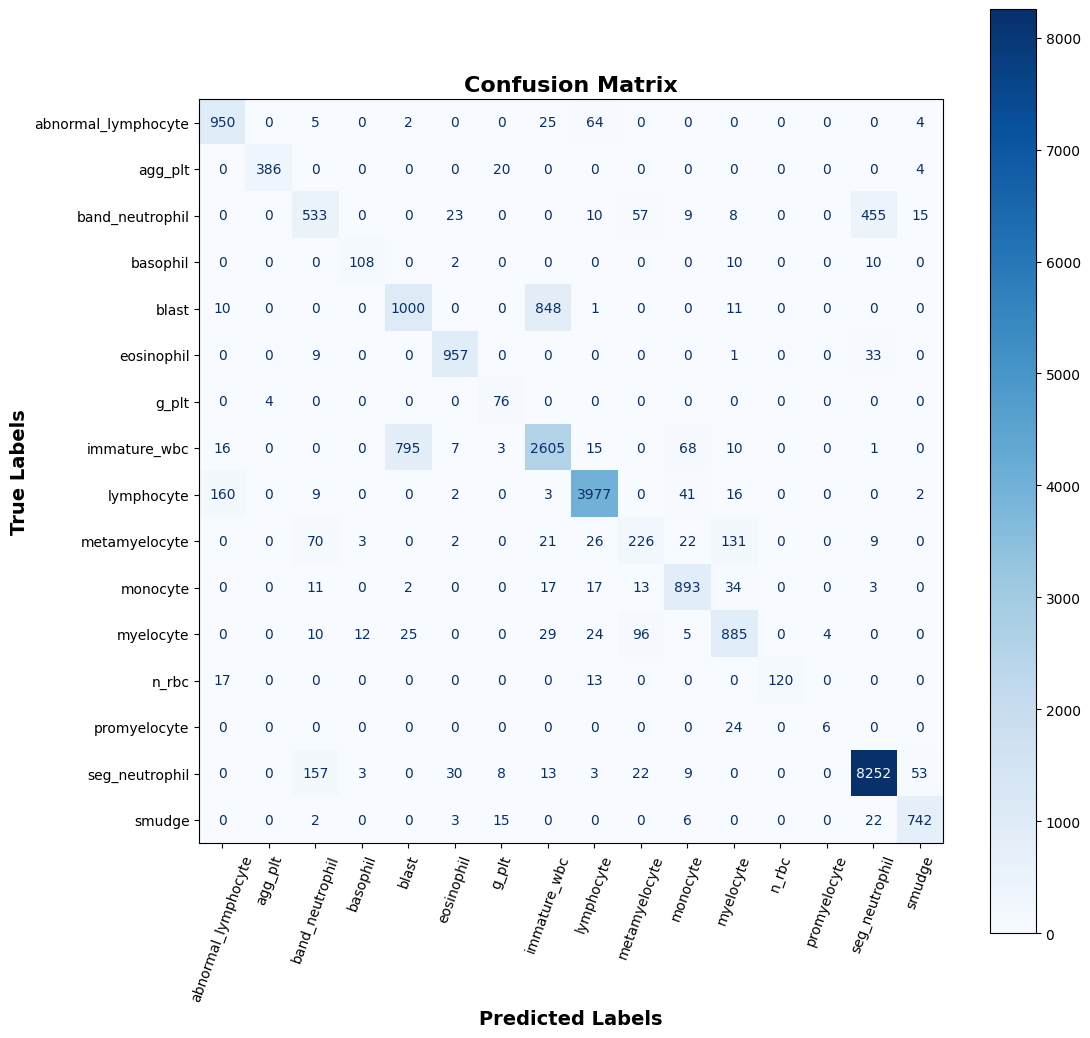

In [11]:
final_cm = sum(CM[:20])  # Sums up elements cm[0] to cm[19]

# Create display labels
class_names = sorted_class
plt.figure(figsize=(12, 12))
# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)

## Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=True)
## Rotate x-axis labels
plt.xticks(rotation=70)

# Customize the title and axis labels
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=14, fontweight='bold')
plt.ylabel("True Labels", fontsize=14, fontweight='bold')

#plt.tight_layout()
plt.show()

In [47]:
y_true = list(chain.from_iterable(Y))
y_gt = list(chain.from_iterable(Pred))

In [48]:
# Print classification report
report = classification_report(y_true, y_gt, target_names=[f"Class {i}" for i in range(16)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      2090
     Class 1       1.00      1.00      1.00       808
     Class 2       1.00      1.00      1.00      2212
     Class 3       1.00      1.00      1.00       254
     Class 4       1.00      1.00      1.00      3724
     Class 5       1.00      1.00      1.00      1996
     Class 6       1.00      1.00      1.00       148
     Class 7       1.00      1.00      1.00      7038
     Class 8       1.00      1.00      1.00      8418
     Class 9       1.00      0.99      1.00      1012
    Class 10       1.00      1.00      1.00      1978
    Class 11       1.00      1.00      1.00      2174
    Class 12       1.00      1.00      1.00       286
    Class 13       1.00      1.00      1.00        48
    Class 14       1.00      1.00      1.00     17092
    Class 15       1.00      1.00      1.00      1564

    accuracy                           1.00     50842
  

In [63]:
chunk = 9
best_model.evaluate(x_test_chunk[chunk], y_test_encoded_chunk[chunk], batch_size=40, verbose=1)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9704 - loss: 0.1134


[0.20860594511032104, 0.9529227018356323]

In [62]:
y_pred = best_model.predict(x_test_chunk[9], batch_size=20,  verbose=1)

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [59]:
sparse_gt = np.argmax(y_test_encoded_chunk[chunk], axis=1)
sparse_pred = np.argmax(y_pred, axis=1)

print(sparse_gt.shape)
print(sparse_pred.shape)

(2549,)
(2549,)


In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix

Accuracy: 0.5810121616320125
F1 Score (macro): 0.19237169640395446
F1 Score (micro): 0.5810121616320125
Recall (macro): 0.16690119834916214
Recall (micro): 0.5810121616320125
Precision (macro): 0.23675213675213677
Precision (micro): 0.5810121616320125


Confusion Matrix:


/root/miniconda3/envs/tff/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


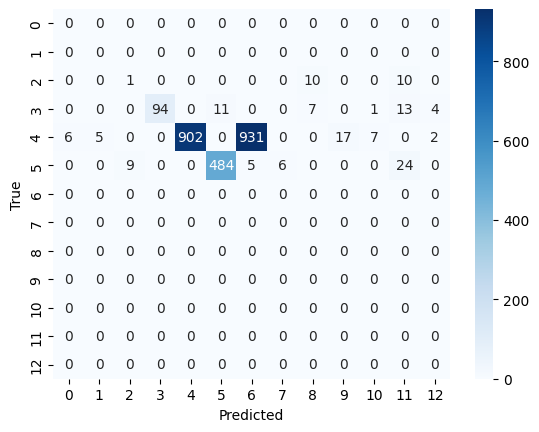

In [60]:
# Calculate accuracy
accuracy = accuracy_score(sparse_gt, sparse_pred)
print("Accuracy:", accuracy)

# F1 Score (macro)
f1_macro = f1_score(sparse_gt, sparse_pred, average='macro')
print("F1 Score (macro):", f1_macro)

# F1 Score (micro)
f1_micro = f1_score(sparse_gt, sparse_pred, average='micro')
print("F1 Score (micro):", f1_micro)

# Recall (macro)
recall_macro = recall_score(sparse_gt, sparse_pred, average='macro')
print("Recall (macro):", recall_macro)

# Recall (micro)
recall_micro = recall_score(sparse_gt, sparse_pred, average='micro')
print("Recall (micro):", recall_micro)

# Precision (macro)
precision_macro = precision_score(sparse_gt, sparse_pred, average='macro')
print("Precision (macro):", precision_macro)

# Precision (micro)
precision_micro = precision_score(sparse_gt, sparse_pred, average='micro')
print("Precision (micro):", precision_micro)

# Confusion Matrix
cm = confusion_matrix(sparse_gt, sparse_pred)
print("\n\nConfusion Matrix:")
#print(cm)
# Visualize the confusion matrix using seaborn
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy is: 70.06669282071401
Sensitivity :  1.0
Specificity :  1.0
PPV :  1.0
NPV :  1.0


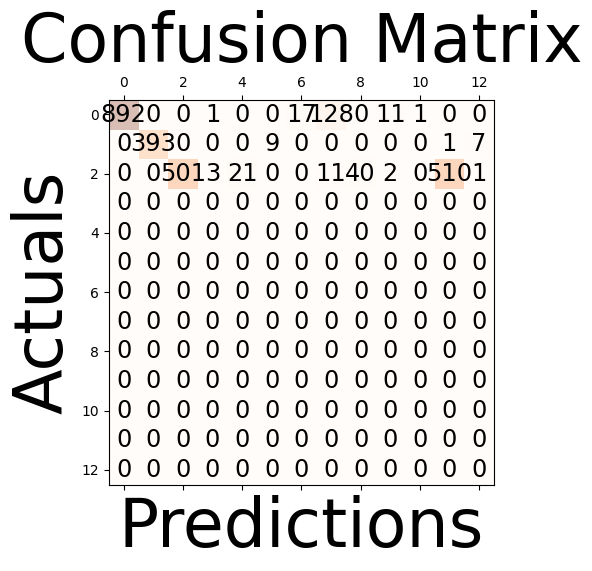

In [31]:
#y_pred = best_model.predict(x=X_test, batch_size = 300)    
a = accuracy_score(sparse_gt, sparse_pred.round())
print('Accuracy is:', a*100)

conf_matrix = confusion_matrix(y_true=sparse_gt, y_pred=sparse_pred.round())

sensitivity1 = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
print('Sensitivity : ', sensitivity1 )
specificity1 = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
print('Specificity : ', specificity1)

PPV1 = conf_matrix[1,1]/(conf_matrix[0,1]+conf_matrix[1,1])
print('PPV : ', PPV1 )
NPV1 = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0])
print('NPV : ', NPV1)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=48)
plt.ylabel('Actuals', fontsize=48)
plt.title('Confusion Matrix', fontsize=48)
#plt.savefig('C:/Users/Dhruba/Codes/Slice_selection confusion_matrix.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
plt.show()

In [22]:
model.evaluate(x_test, y_test_encoded, batch_size=1, verbose=1)

25490/25490 ━━━━━━━━━━━━━━━━━━━━ 134s 5ms/step - accuracy: 0.7047 - loss: 0.7757


[0.49749448895454407, 0.8391526341438293]

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [ ]:
# class EvaluateCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         loss, accuracy = self.model.evaluate(x_test, y_test_encoded, verbose=1, batch_size=10)
#         print(f'Epoch {epoch+1}: Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')

In [ ]:
# def dense_block(x, repetitions, filters):
#     for _ in range(repetitions):
#         y = BatchNormalization()(x)
#         y = ReLU()(y)
#         y = Conv2D(4 * filters, 1, padding='same')(y)
#         y = BatchNormalization()(y)
#         y = ReLU()(y)
#         y = Conv2D(filters, 3, padding='same')(y)
#         x = concatenate([y, x])
#     return x

# def transition_layer(x):
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = Conv2D(K.int_shape(x)[-1] // 2, 1, padding='same')(x)
#     x = AvgPool2D(2, strides=2, padding='same')(x)
#     return x

# def DenseNet121(input_shape=(128, 128, 3), num_classes=16):
#     inputs = Input(input_shape)

#     x = Conv2D(64, 7, strides=2, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = MaxPool2D(3, strides=2, padding='same')(x)

#     x = dense_block(x, 6, 32)
#     x = transition_layer(x)
#     x = Dropout(0.1)(x)

#     x = dense_block(x, 12, 32)
#     x = transition_layer(x)
#     x = Dropout(0.1)(x)
    
#     x = dense_block(x, 24, 32)
#     x = transition_layer(x)
#     x = Dropout(0.1)(x)

#     x = dense_block(x, 16, 32)
#     x = Dropout(0.1)(x)

#     x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
#     outputs = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs, outputs)
#     return model

# model = DenseNet121()
# #model.summary()

In [2]:
# def dense_block(x, repetitions, filters):
#     for _ in range(repetitions):
#         y = BatchNormalization()(x)
#         y = ReLU()(y)
#         y = Conv2D(4 * filters, 1, padding='same')(y)
#         y = BatchNormalization()(y)
#         y = ReLU()(y)
#         y = Conv2D(filters, 3, padding='same')(y)
#         x = concatenate([y, x])
#     return x

# def transition_layer(x):
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = Conv2D(K.int_shape(x)[-1] // 2, 1, padding='same')(x)
#     x = AvgPool2D(2, strides=2, padding='same')(x)
#     return x

# def DenseNet121(input_shape=(128, 128, 3), num_classes=16):
#     inputs = Input(input_shape)

#     x = Conv2D(64, 7, strides=2, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = MaxPool2D(3, strides=2, padding='same')(x)

#     x = dense_block(x, 6, 32)
#     x = transition_layer(x)

#     x = dense_block(x, 12, 32)
#     x = transition_layer(x)

#     x = dense_block(x, 24, 32)
#     x = transition_layer(x)

#     x = dense_block(x, 16, 32)

#     x = GlobalAveragePooling2D()(x)
#     outputs = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs, outputs)
#     return model

# model = DenseNet121()
# model.summary()

I0000 00:00:1732459688.917243   22897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732459689.106123   22897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732459689.106217   22897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732459689.118654   22897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732459689.118722   22897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "WBC_Classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,207,056 (4.60 MB)

 Trainable params: 1,204,368 (4.59 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [ ]:
# def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
#     if conv_shortcut:
#         shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
#         shortcut = BatchNormalization()(shortcut)
#     else:
#         shortcut = x

#     x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)

#     x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
#     x = BatchNormalization()(x)

#     x = Add()([shortcut, x])
#     x = ReLU()(x)

#     return x
    
# def resnet_34(input_shape=(128, 128, 3), num_classes=16):
#     inputs = Input(shape=input_shape)

#     # Initial Conv
#     x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

#     # Residual blocks
#     for size in [64, 128, 256, 512]:
#         strides = 1 if size == 64 else 2
#         x = residual_block(x, size, stride=strides)
#         for _ in range(1, (34-2)//6 if size == 64 else 2):
#             x = residual_block(x, size, conv_shortcut=False)

#     # Global Average Pooling and Fully Connected Layer
#     x = GlobalAveragePooling2D()(x)
#     outputs = Dense(num_classes, activation='softmax')(x)

#     return tf.keras.models.Model(inputs=inputs, outputs=outputs)

# model = resnet_34()
# #model.summary()

In [ ]:
# def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
#     # 1x1 convolution
#     conv1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

#     # 3x3 convolution
#     conv3x3_reduce = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
#     conv3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv3x3_reduce)

#     # 5x5 convolution
#     conv5x5_reduce = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
#     conv5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv5x5_reduce)

#     # Max pooling followed by 1x1 convolution
#     pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
#     pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

#     # Concatenate all the branches
#     output = concatenate([conv1x1, conv3x3, conv5x5, pool_proj], axis=-1, name=name)
#     return output

# def build_inception_v1(input_shape, num_classes):
#     input_layer = Input(shape=input_shape)

#     # Initial layers
#     x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
#     x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
#     x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
#     x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
#     x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

#     # Inception modules
#     x = inception_module(x, 64, 96, 128, 16, 32, 32, name='inception_3a')
#     x = inception_module(x, 128, 128, 192, 32, 96, 64, name='inception_3b')
#     x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

#     x = inception_module(x, 192, 96, 208, 16, 48, 64, name='inception_4a')
#     x = inception_module(x, 160, 112, 224, 24, 64, 64, name='inception_4b')
#     x = inception_module(x, 128, 128, 256, 24, 64, 64, name='inception_4c')
#     x = inception_module(x, 112, 144, 288, 32, 64, 64, name='inception_4d')
#     x = inception_module(x, 256, 160, 320, 32, 128, 128, name='inception_4e')
#     x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

#     x = inception_module(x, 256, 160, 320, 32, 128, 128, name='inception_5a')
#     x = inception_module(x, 384, 192, 384, 48, 128, 128, name='inception_5b')

#     # Global average pooling and dropout
#     x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)

#     # Fully connected layer (output layer)
#     output_layer = Dense(num_classes, activation='softmax')(x)

#     # Create the model
#     model = Model(input_layer, output_layer, name='InceptionV1')
#     return model

# # Example usage
# input_shape = (128, 128, 3)  # Image size
# num_classes = 16  # Number of classes
# model = build_inception_v1(input_shape, num_classes)

# # Compile the model
# #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Summary of the model
# model.summary()